# Beam Blockage calculations (Baler Radar)

Author: [Irene Crisologo](http://philippineradarnetwork.wordpress.com)

This notebook is part of a collection of notebooks that demonstrates how to determine and plot the beam blockage map for the different radars in the Philippines.

More specifically, this will demonstrate how to determine the beam blockage map for the **Baler** radar. 

In [1]:
import wradlib as wrl
import netCDF4 as nc
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt

In [2]:
def read_IRIS_netcdf(filename, variable='Z', enforce_equidist=False):
    """Data reader for netCDF files exported by the IRIS radar software

    The netcdf files produced by the IRIS software usually contains two
    variables: reflectivity (Z) and total power (T). The default variable read
    is reflectivity.

    Parameters
    ----------
    filename : path of the netCDF file
    enforce_equidist : boolean
        Set True if the values of the azimuth angles should be forced to be equidistant
        default value is False

    Returns
    -------
    output : numpy array of image data (dBZ), dictionary of attributes

    """
    # read the data from file
    dset = nc.Dataset(filename)
    data = dset.variables[variable][:]
    # Check azimuth angles and rotate image
    az = dset.variables['radialAzim'][:]
    # These are the indices of the minimum and maximum azimuth angle
    ix_minaz = np.argmin(az)
    ix_maxaz = np.argmax(az)
##    if enforce_equidist:
##        az = np.linspace(np.round(az[ix_minaz],2), np.round(az[ix_maxaz],2), len(az))
##    else:
##        az = np.roll(az, -ix_minaz)
##    # rotate accordingly
##    data = np.roll(data, -ix_minaz, axis=0)
    data = np.where(data==dset.variables[variable].getncattr('_FillValue'), np.nan, data)
    # Ranges
    binwidth = dset.variables['gateSize'][:]
    r = np.arange(binwidth, (dset.variables['Z'].shape[-1]*binwidth) + binwidth, binwidth)
    # collect attributes
    attrs =  {}
    for attrname in dset.ncattrs():
        attrs[attrname] = dset.getncattr(attrname)

    # Set additional metadata attributes
    attrs['az'] = az
    attrs['r']  = r
    attrs['ElevationAngle'] = dset.variables['elevationAngle'][:]
    attrs['firstGateRange'] = dset.variables['firstGateRange'][:]
    attrs['gateSize'] = dset.variables['gateSize'][:]
    attrs['nyquist'] = dset.variables['nyquist'][:]
    attrs['unambigRange'] = dset.variables['unambigRange'][:]
    attrs['calibConst'] = dset.variables['calibConst'][:]
    attrs['Longitude'] = dset.variables['siteLat'][:]
    attrs['Latitude'] = dset.variables['siteLon'][:]
    attrs['sitecoords'] = (float(dset.variables['siteLat'][:]), float(dset.variables['siteLon'][:]),
                           float(dset.variables['siteAlt'][:]))
    attrs['Time'] = dt.datetime.utcfromtimestamp(dset.variables['esStartTime'][:])
    attrs['max_range'] = data.shape[1] * binwidth
    dset.close()

    return data, attrs

In [3]:
radarshortname = 'bal'

fname = '../phirad-data/radars/baler/Output07BAL150710000016.RAWA77H_sweep1.nc'  # elev = 0.5

data, attrs = read_IRIS_netcdf(fname)

In [4]:
# setup radar specs
sitecoords = attrs['sitecoords']
nrays = len(attrs['az'])
nbins = len(attrs['r'])
nbins = 500
el = attrs['ElevationAngle']
#el = 1.5
bw = 1.0
range_res = 240
print sitecoords
print el
print nbins

(121.63343048095703, 15.750189781188965, 188.0)
0.499877929688
500


In [5]:
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [6]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
lon, lat, alt = np.array(
    wrl.georef.polar2lonlatalt_n(coord[..., 0], np.degrees(coord[..., 1]),
                                 coord[..., 2], sitecoords))
polcoords = np.dstack((lon, lat))
print("lon,lat,alt:", lon.shape, lat.shape, alt.shape)

# get radar bounding box lonlat
lonmin = np.min(lon)
lonmax = np.max(lon)
latmin = np.min(lat)
latmax = np.max(lat)
rlimits = [lonmin, latmin, lonmax, latmax]
print("radar bounding box:", rlimits)

('lon,lat,alt:', (360L, 500L), (360L, 500L), (360L, 500L))
('radar bounding box:', [120.51452765823149, 14.673312357812895, 122.75229890426209, 16.827067533478399])


### Read DEM Raster Data

In [7]:
# read raster data
rastercoords, rastervalues = wrl.io.read_raster_data('../phirad-data/dem/SRTM_BAL.tif')

# apply radar bounding box to raster data
# this actually cuts out the interesting box from rasterdata
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

# map rastervalues to polar grid points
polarvalues = wrl.ipol.cart2irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

print(polarvalues.shape)

(360L, 500L)


In [8]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360L, 500L)


In [9]:
# calculate cumulative beam blockage CBB
ind = np.nanargmax(PBB, axis=1)
CBB = np.copy(PBB)
for ii, index in enumerate(ind):
    CBB[ii, 0:index] = PBB[ii, 0:index]
    CBB[ii, index:] = PBB[ii, index]

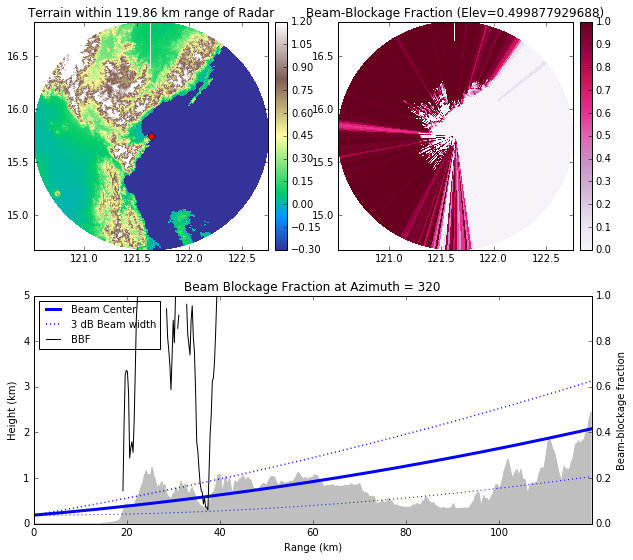

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plotting the stuff
fig = pl.figure(figsize=(10, 9))

# create subplots
ax1 = pl.subplot2grid((2, 2), (0, 0))
ax2 = pl.subplot2grid((2, 2), (0, 1))
ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 320

# plot terrain
dem = ax1.pcolormesh(lon, lat, polarvalues / 1000., cmap=mpl.cm.terrain,
                     vmin=-0.3, vmax=1.2)
ax1.plot(sitecoords[0], sitecoords[1], 'rD')
ax1.set_title(
    'Terrain within {0} km range of Radar'.format(np.max(r / 1000.) + 0.1))
# colorbar
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(dem, cax=cax1)
# limits

ax1.set_xlim(lonmin, lonmax)
ax1.set_ylim(latmin, latmax)
ax1.set_aspect('auto')

# plot CBB on ax2
cbb = ax2.pcolormesh(lon, lat, CBB, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
ax2.set_title('Beam-Blockage Fraction (Elev=%s)'%el)
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.1)
# colorbar
fig.colorbar(cbb, cax=cax2)
# limits
ax2.set_xlim(lonmin, lonmax)
ax2.set_ylim(latmin, latmax)
ax2.set_aspect('auto')

# plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :] / 1000., '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius) / 1000., ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius) / 1000., ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :] / 1000.,
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 5)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Height (km)')
ax3.set_title('Beam Blockage Fraction at Azimuth = %s'%angle)

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)

legend = ax3.legend((bc, b3db, bbf), ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

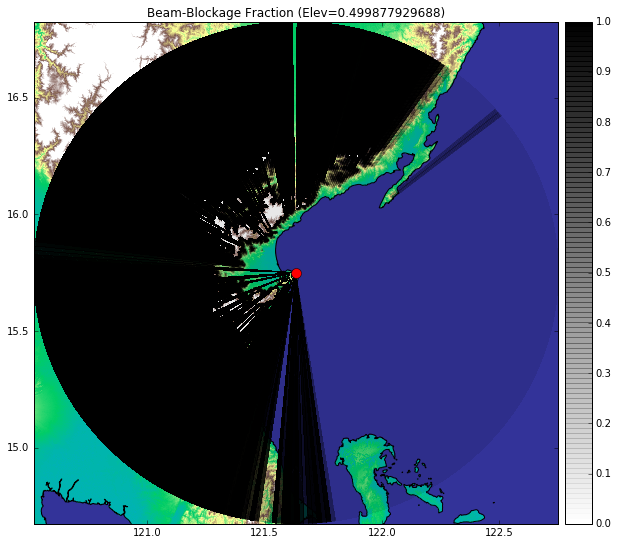

In [11]:
# Read shapefile for overlay
PATH_Ph_shapefile = '../phirad-data/shapefiles/Country/Country.shp'
dataset, inLayer = wrl.io.open_shape(PATH_Ph_shapefile)
borders, keys = wrl.georef.get_shape_coordinates(inLayer)

raster_lon = rastercoords[...,...,0]
raster_lat = rastercoords[...,...,1]

import matplotlib.colors as mcolors

# set up a linear colormap which is red and only changes alpha
# (1,0,0,1) --> (1,0,0,0) 
colors = [(0,0,0,1-i) for i in np.linspace(1,0,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)

fig = pl.figure(figsize=(10, 9))
ax1 = pl.subplot(111)

pl.plot(sitecoords[0],sitecoords[1],'ro',ms=10)
dem = ax1.pcolormesh(raster_lon, raster_lat, rastervalues / 1000., cmap=mpl.cm.terrain,
                     vmin=-0.3, vmax=1.2)
shade = np.empty_like(CBB)
shade[:,:] = 0.1
sh = ax1.contourf(lon, lat, shade, cmap=cmap, vmin=0, vmax=1)
cbb = ax1.pcolormesh(lon, lat, CBB, cmap=cmap, vmin=0, vmax=1)
wrl.vis.add_lines(ax1, borders, color='black', lw=1.)
ax1.set_title('Beam-Blockage Fraction (Elev=%s)'%el)
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
# colorbar
fig.colorbar(cbb, cax=cax1)
# limits
ax1.set_xlim(lonmin, lonmax)
ax1.set_ylim(latmin, latmax)
ax1.set_aspect('auto')
#pl.savefig(radarshortname+'.png')